# LOgs

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import pickle

# Paths
base = "/triumvirate/home/alexarol/breast_cancer_analysis"

preb_csv = (
    f"{base}/results/recode_outputs/preneoplastic/"
    "BRCA1_PreNeoplastic_RECODE_sig_genes_cellsxgenes_forWGCNA.csv"
)
sig_genes_path_preb = (
    f"{base}/results/recode_outputs/preneoplastic/"
    "BRCA1_PreNeoplastic_RECODE_sig_genes_atleast2.txt"
)

sample_label = "PreB"
n_cells_expected = 7644

# Helper functions

In [2]:
def add_mito_qc(adata: sc.AnnData) -> sc.AnnData:
    """Flag mitochondrial genes and compute QC metrics."""
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars=["mt"],
        percent_top=None,
        log1p=False,
        inplace=True,
    )
    return adata


def summarize_qc(adata, sample_name="sample"):
    """Print QC summary: median, IQR, whiskers for violin metrics."""
    obs = adata.obs
    metrics = ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"]
    print(f"QC summary for {sample_name}")
    print("-" * 60)
    for m in metrics:
        s = obs[m]
        desc = s.describe()
        q1, q3 = desc["25%"], desc["75%"]
        iqr = q3 - q1
        lower_whisker = q1 - 1.5 * iqr
        upper_whisker = q3 + 1.5 * iqr
        print(
            f"{m}: median={desc['50%']:.1f}, IQR=[{q1:.1f}, {q3:.1f}], "
            f"whiskers≈[{lower_whisker:.1f}, {upper_whisker:.1f}], "
            f"min={desc['min']:.1f}, max={desc['max']:.1f}"
        )
    print()


def suggest_qc_thresholds(adata, fixed_min_genes=200, max_mt_cap=20.0):
    """Suggest data-driven QC thresholds from violin distributions."""
    obs = adata.obs
    
    def whiskers(x):
        desc = x.describe()
        q1, q3 = desc["25%"], desc["75%"]
        iqr = q3 - q1
        return q1 - 1.5 * iqr, q3 + 1.5 * iqr
    
    low_w_genes, high_w_genes = whiskers(obs["n_genes_by_counts"])
    min_genes = max(fixed_min_genes, low_w_genes, 0)
    max_genes = high_w_genes
    
    _, high_w_counts = whiskers(obs["total_counts"])
    max_counts = high_w_counts
    
    _, high_w_mt = whiskers(obs["pct_counts_mt"])
    max_pct_mt = min(high_w_mt, max_mt_cap)
    
    thresholds = {
        "min_genes": float(min_genes),
        "max_genes": float(max_genes),
        "max_counts": float(max_counts),
        "max_pct_mt": float(max_pct_mt),
    }
    
    print("Suggested QC thresholds (from violins):")
    for k, v in thresholds.items():
        print(f"  {k}: {v:.2f}")
    print()
    
    return thresholds

# Load initial matrix and build adata_preb

In [3]:
# Load significant genes
sig_genes = pd.read_csv(sig_genes_path_preb)["gene"].astype(str).tolist()

# Read header to get columns
all_cols = pd.read_csv(preb_csv, nrows=0).columns.astype(str).tolist()
cell_col = all_cols[0]
expr_cols = all_cols[1:]

# Intersect with sig genes
genes = pd.Index(sig_genes).intersection(expr_cols)

if len(genes) == 0:
    raise ValueError(
        f"No overlap between sig_genes ({len(sig_genes)}) and PreB columns "
        f"({len(expr_cols)}). Check gene naming / capitalization."
    )

# Cap at 10000 for initial QC/visualization
max_genes = 10000
if len(genes) > max_genes:
    genes = genes[:max_genes]

usecols = [cell_col] + genes.tolist()

print(f"Loading {sample_label} data with {len(genes)} genes for QC")
df = pd.read_csv(
    preb_csv,
    usecols=usecols,
    dtype={cell_col: str}
)

expr = df.iloc[:, 1:].copy()
expr.index = df.iloc[:, 0].astype(str)

expr = expr.apply(pd.to_numeric, errors="coerce")

adata_preb = sc.AnnData(X=expr.values)
adata_preb.obs_names = expr.index
adata_preb.var_names = expr.columns.astype(str)

print(f"Initial shape ({sample_label}): {adata_preb.shape}")

Loading PreB data with 10000 genes for QC
Initial shape (PreB): (7644, 10000)


# Flag mitochondrial and ribosomal genes, compute QC

In [4]:
# Mitochondrial
adata_preb = add_mito_qc(adata_preb)

# Ribosomal (KEGG_RIBOSOME gene set)
ribo_url = (
    "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp"
    "?geneSetName=KEGG_RIBOSOME&fileType=txt"
)
ribo_genes = pd.read_table(ribo_url, skiprows=2, header=None)
ribo_symbols = ribo_genes[0].values
adata_preb.var["ribo"] = adata_preb.var_names.isin(ribo_symbols)

# Recompute QC with ribo
sc.pp.calculate_qc_metrics(
    adata_preb,
    qc_vars=["mt", "ribo"],
    percent_top=None,
    log1p=False,
    inplace=True,
)

print(adata_preb)
adata_preb.obs.head()
adata_preb.var.head()

AnnData object with n_obs × n_vars = 7644 × 10000
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'


mt  n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
A1BG      False                648     0.099686              91.522763   
A1BG-AS1  False                205     0.028127              97.318158   
A2M       False                279     0.044087              96.350078   
A2M-AS1   False                  5     0.000654              99.934589   
A2ML1     False                 18     0.002486              99.764521   

          total_counts   ribo  
A1BG               762  False  
A1BG-AS1           215  False  
A2M                337  False  
A2M-AS1              5  False  
A2ML1               19  False

# Filter genes with min_cells ≥ 3 (chunked)

In [5]:
print(f"Genes before filtering ({sample_label}): {adata_preb.n_vars}")

gene_counts = np.zeros(adata_preb.n_vars, dtype=np.int64)
chunksize = 2000
n_chunks = int(np.ceil(adata_preb.n_obs / chunksize))

print(f"Counting gene presence across {adata_preb.n_obs} cells in {n_chunks} chunks")
for i in range(n_chunks):
    start = i * chunksize
    end = min((i + 1) * chunksize, adata_preb.n_obs)
    
    chunk = adata_preb.X[start:end, :]
    
    if hasattr(chunk, "toarray"):
        chunk = chunk.toarray()
    
    gene_counts += (chunk > 0).sum(axis=0)
    
    if (i + 1) % 10 == 0 or i == n_chunks - 1:
        print(f"  Processed chunk {i+1}/{n_chunks}")

genes_keep_mask = gene_counts >= 3
print(f"Genes passing min_cells=3: {genes_keep_mask.sum()} / {adata_preb.n_vars}")

adata_preb = adata_preb[:, genes_keep_mask]
print(f"Genes after filtering ({sample_label}): {adata_preb.n_vars}")

Genes before filtering (PreB): 10000
Counting gene presence across 7644 cells in 4 chunks
  Processed chunk 4/4
Genes passing min_cells=3: 8589 / 10000
Genes after filtering (PreB): 8589


# Pre‑QC violins, threshold suggestion, and QC filtering


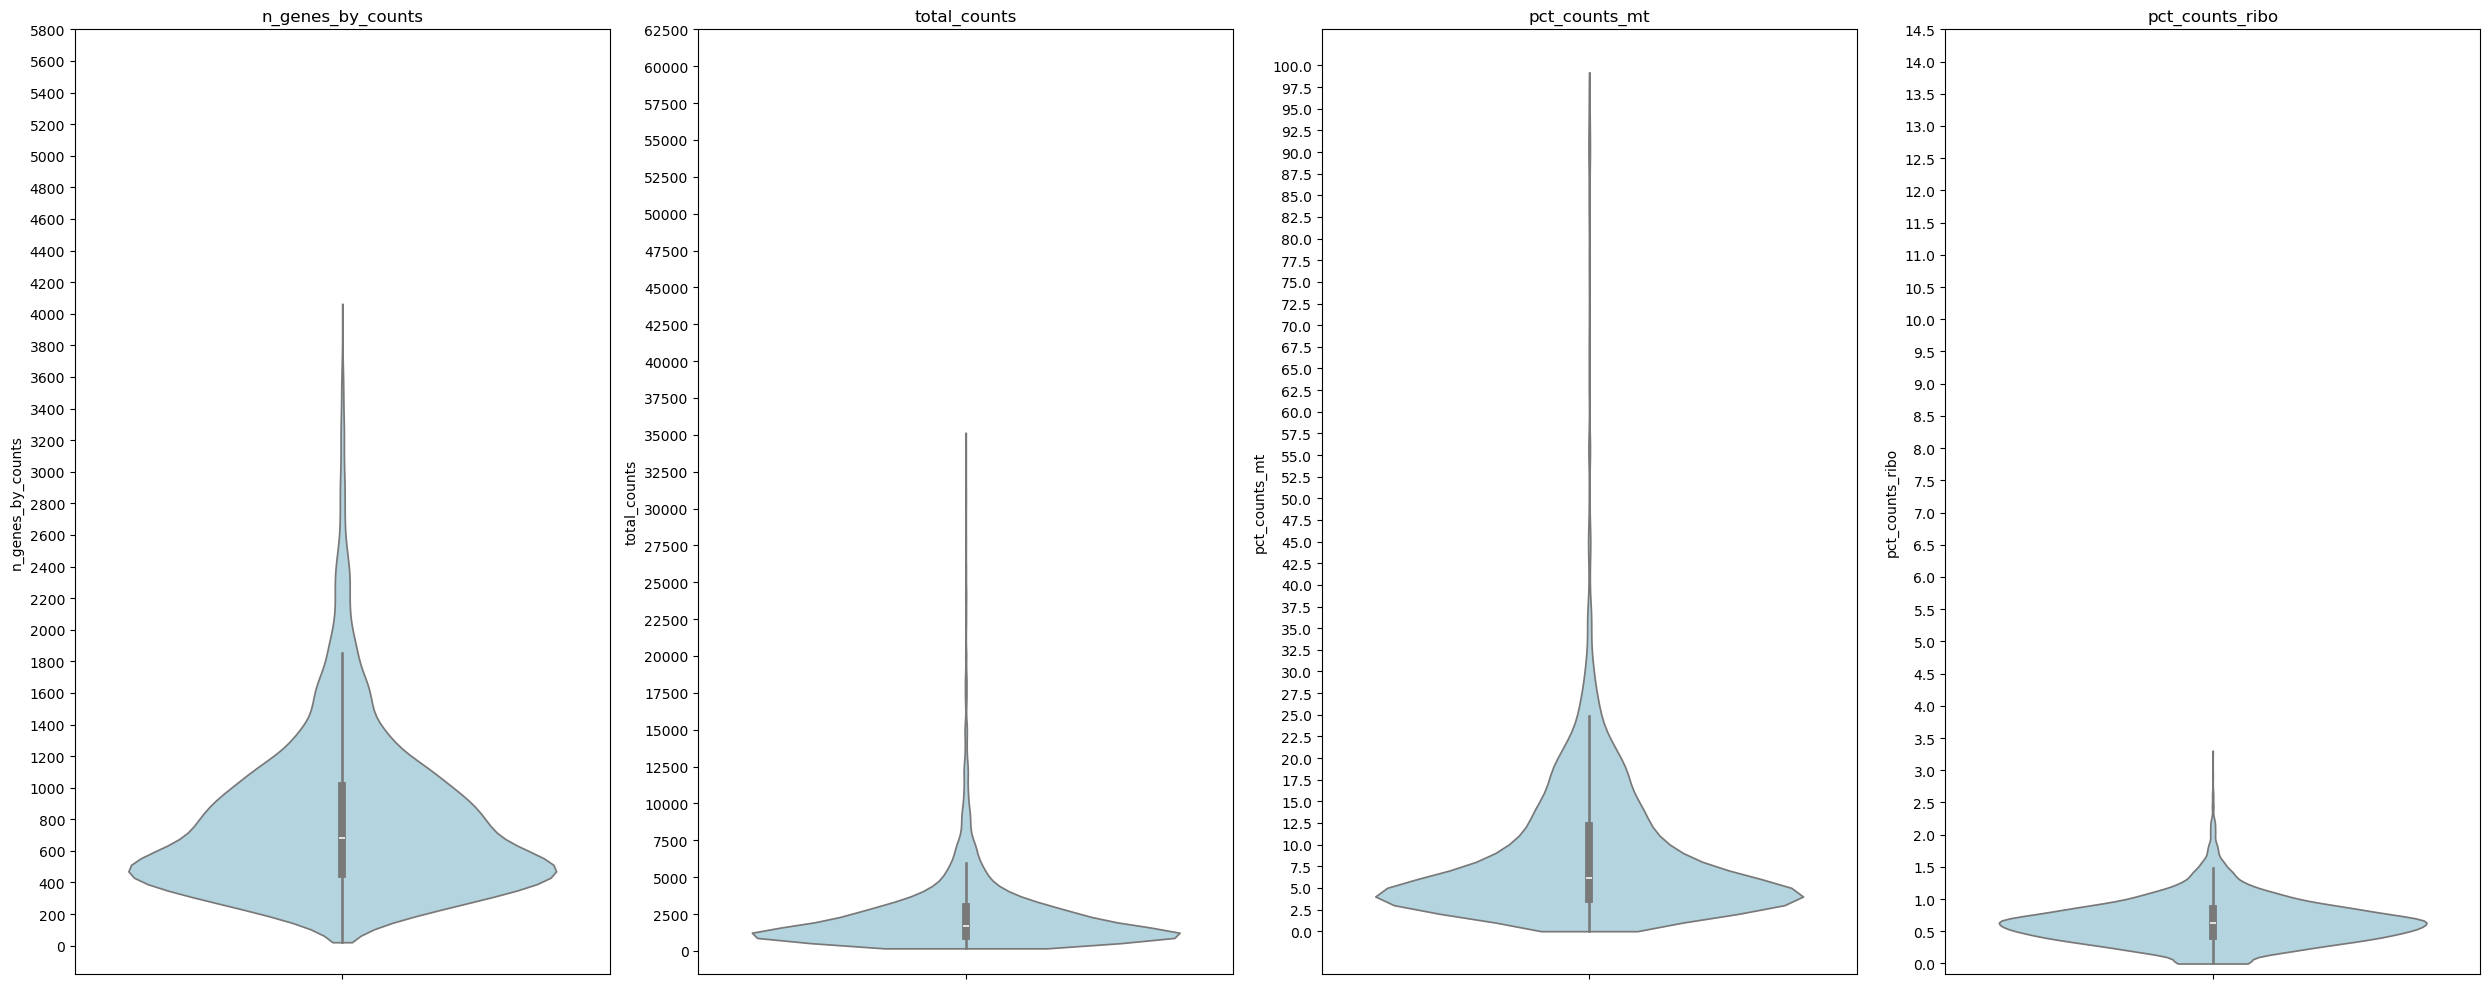

QC summary for BRCA1-Preneoplastic
------------------------------------------------------------
n_genes_by_counts: median=679.0, IQR=[451.0, 1013.2], whiskers≈[-392.4, 1856.6], min=22.0, max=4063.0
total_counts: median=1694.0, IQR=[994.0, 2972.2], whiskers≈[-1973.4, 5939.6], min=172.0, max=35144.0
pct_counts_mt: median=6.2, IQR=[3.7, 12.2], whiskers≈[-9.0, 24.8], min=0.0, max=99.2
pct_counts_ribo: median=0.6, IQR=[0.4, 0.8], whiskers≈[-0.2, 1.5], min=0.0, max=3.3

Suggested QC thresholds (from violins):
  min_genes: 200.00
  max_genes: 1856.62
  max_counts: 5939.62
  max_pct_mt: 20.00

Cells before QC (PreB): 7644
Cells after QC (PreB): 6905
6905 cells remain after QC (PreB)


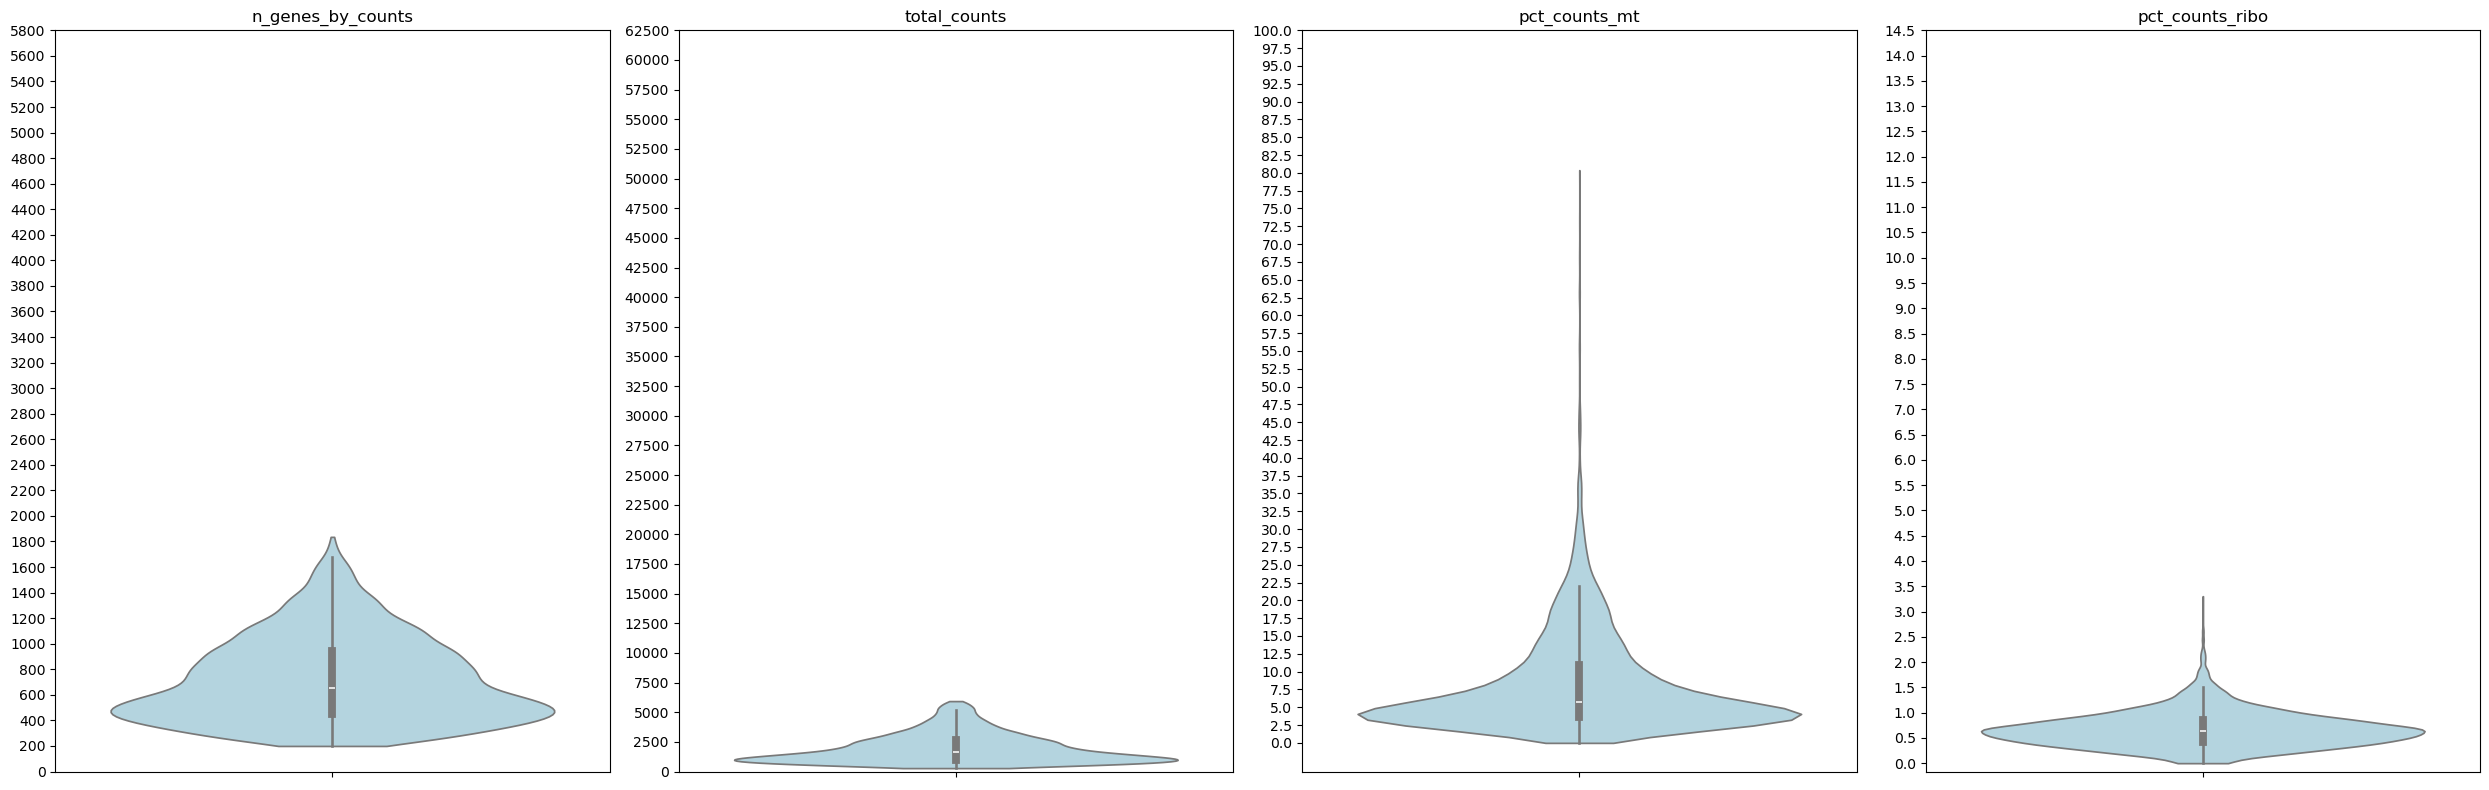

In [6]:
metrics = ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"]

# Pre-QC violins
fig, axes = plt.subplots(1, 4, figsize=(25, 10))

for i, m in enumerate(metrics):
    sns.violinplot(
        y=adata_preb.obs[m],
        ax=axes[i],
        inner="box",
        cut=0,
        color="lightblue",
    )
    axes[i].set_title(m)

axes[0].set_yticks(np.arange(0, 6000, 200))
axes[1].set_yticks(np.arange(0, 65000, 2500))
axes[2].set_yticks(np.arange(0, 101, 2.5))
axes[3].set_yticks(np.arange(0, 15.0, 0.5))

plt.tight_layout()
plt.show()

summarize_qc(adata_preb, sample_name="BRCA1-Preneoplastic")
thr_preb = suggest_qc_thresholds(adata_preb)

# Optional: override mito if you want same reasoning as other samples
thr_preb["max_pct_mt"] = None

obs = adata_preb.obs
mask = (
    (obs["n_genes_by_counts"] >= thr_preb["min_genes"]) &
    (obs["n_genes_by_counts"] <= thr_preb["max_genes"]) &
    (obs["total_counts"] <= thr_preb["max_counts"])
)

print(f"Cells before QC ({sample_label}): {adata_preb.n_obs}")
print(f"Cells after QC ({sample_label}): {mask.sum()}")

adata_preb = adata_preb[mask]
print(f"{adata_preb.n_obs} cells remain after QC ({sample_label})")

# Post-QC violins
fig, axes = plt.subplots(1, 4, figsize=(25, 8))

for i, m in enumerate(metrics):
    sns.violinplot(
        y=adata_preb.obs[m],
        ax=axes[i],
        inner="box",
        cut=0,
        color="lightblue",
    )
    axes[i].set_title(m, fontsize=12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

axes[0].set_yticks(np.arange(0, 6000, 200))
axes[1].set_yticks(np.arange(0, 65000, 2500))
axes[2].set_yticks(np.arange(0, 101, 2.5))
axes[3].set_yticks(np.arange(0, 15.0, 0.5))

plt.tight_layout()
plt.show()

# Save QC‑passed cell IDs

In [7]:
qc_cells = adata_preb.obs_names.to_list()
qc_cells_preb_file = "PreB_QC_cells.txt"
pd.Series(qc_cells).to_csv(qc_cells_preb_file, index=False, header=False)
print(f"Saved {len(qc_cells)} QC-passed cell IDs to {qc_cells_preb_file}")

Saved 6905 QC-passed cell IDs to PreB_QC_cells.txt


# Chunked normalization (CP10k + log1p)


In [8]:
qc_cells = set(adata_preb.obs_names.astype(str).tolist())
genes_keep = adata_preb.var_names.astype(str).tolist()

chunk_iter = pd.read_csv(preb_csv, index_col=0, chunksize=800)

out_path = "PreB_QC_CP10k_log1p_forWGCNA.csv"
first_chunk = True

print("Starting chunked normalization for PreB")
for i, chunk in enumerate(chunk_iter):
    if i % 50 == 0:
        print(f"  Processing chunk {i}")
    
    chunk.index = chunk.index.astype(str)
    
    chunk = chunk.loc[chunk.index.intersection(qc_cells)]
    if chunk.empty:
        continue
    
    cols = [g for g in genes_keep if g in chunk.columns]
    chunk = chunk[cols]
    
    lib_size = chunk.sum(axis=1)
    chunk_norm = chunk.div(lib_size, axis=0) * 1e4
    chunk_log = np.log1p(chunk_norm)
    
    if first_chunk:
        chunk_log.to_csv(out_path)
        first_chunk = False
    else:
        chunk_log.to_csv(out_path, mode="a", header=False)

print(f"Normalized matrix saved to {out_path}")

Starting chunked normalization for PreB
  Processing chunk 0


/triumvirate/apps/.scratch/alexarol/ipykernel_287275/3051262860.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_iter):


Normalized matrix saved to PreB_QC_CP10k_log1p_forWGCNA.csv


# Verify normalized matrix dimensions

In [9]:
n_cells = 0
n_genes = None

chunk_iter = pd.read_csv(out_path, index_col=0, chunksize=500, low_memory=False)
for ch in chunk_iter:
    n_cells += ch.shape[0]
    if n_genes is None:
        n_genes = ch.shape[1]

print(f"Normalized matrix ({sample_label}): {n_cells} cells × {n_genes} genes")

Normalized matrix (PreB): 6905 cells × 8589 genes


# Compute HVGs (3000 genes, chunked variance)


In [10]:
file_path = out_path
chunksize = 500

n_genes_hvg = None
gene_sum = None
gene_sq_sum = None
n_cells_hvg = 0

chunk_iter = pd.read_csv(file_path, index_col=0, chunksize=chunksize, low_memory=False)

print("Computing per-gene mean and variance (PreB)")
for ch in chunk_iter:
    ch_values = ch.values.astype(float)
    if n_genes_hvg is None:
        n_genes_hvg = ch_values.shape[1]
        gene_sum = np.zeros(n_genes_hvg, dtype=np.float64)
        gene_sq_sum = np.zeros(n_genes_hvg, dtype=np.float64)
    
    n = ch_values.shape[0]
    n_cells_hvg += n
    gene_sum += ch_values.sum(axis=0)
    gene_sq_sum += (ch_values ** 2).sum(axis=0)

gene_mean = gene_sum / n_cells_hvg
gene_var = gene_sq_sum / n_cells_hvg - gene_mean**2

chunk_iter = pd.read_csv(file_path, index_col=0, nrows=1)
gene_names = chunk_iter.columns.to_numpy()

hvg_stats = pd.DataFrame({
    "gene": gene_names,
    "mean": gene_mean,
    "var": gene_var
})

hvg_stats_sorted = hvg_stats.sort_values("var", ascending=False)
top_n = 3000
hvg_3000 = hvg_stats_sorted.head(top_n)["gene"].tolist()

print(f"{len(hvg_3000)} HVGs selected for PreB")

hvg_file = "PreB_HVG_3000.txt"
pd.Series(hvg_3000).to_csv(hvg_file, index=False, header=False)
print(f"HVG list saved to {hvg_file}")

Computing per-gene mean and variance (PreB)
3000 HVGs selected for PreB
HVG list saved to PreB_HVG_3000.txt


# Build HVG AnnData for clustering

In [11]:
hvg_3000 = pd.read_csv("PreB_HVG_3000.txt", header=None)[0].astype(str).tolist()

file_path = out_path
chunksize = 800

cell_ids = []
rows = []

chunk_iter = pd.read_csv(file_path, index_col=0, chunksize=chunksize, low_memory=False)

print("Building HVG AnnData (PreB)")
for ch in chunk_iter:
    ch = ch[hvg_3000]
    cell_ids.extend(ch.index.astype(str).tolist())
    rows.append(ch.values.astype(np.float32))

X = np.vstack(rows)

adata_preb_hvg = sc.AnnData(X=X)
adata_preb_hvg.obs_names = cell_ids
adata_preb_hvg.var_names = hvg_3000

adata_preb_hvg.obs = adata_preb.obs.loc[adata_preb_hvg.obs_names].copy()

print(f"HVG AnnData shape ({sample_label}): {adata_preb_hvg.shape}")
print(adata_preb_hvg.obs.head())

Building HVG AnnData (PreB)
HVG AnnData shape (PreB): (6905, 3000)
    n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt  \
4                 512          1399               39       2.787706   
6                1287          4508             1224      27.151730   
8                1128          2815              529      18.792185   
9                 337           682               22       3.225806   
11               1344          5287              316       5.976925   

    total_counts_ribo  pct_counts_ribo  
4                  18         1.286633  
6                  26         0.576752  
8                  15         0.532860  
9                   5         0.733138  
11                 39         0.737658  


# Quick gene correlation heatmap (top 50 variable HVGs)

/triumvirate/apps/.scratch/alexarol/ipykernel_287275/1781441423.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  subset = pd.read_csv(file_path, index_col=0, nrows=5000)


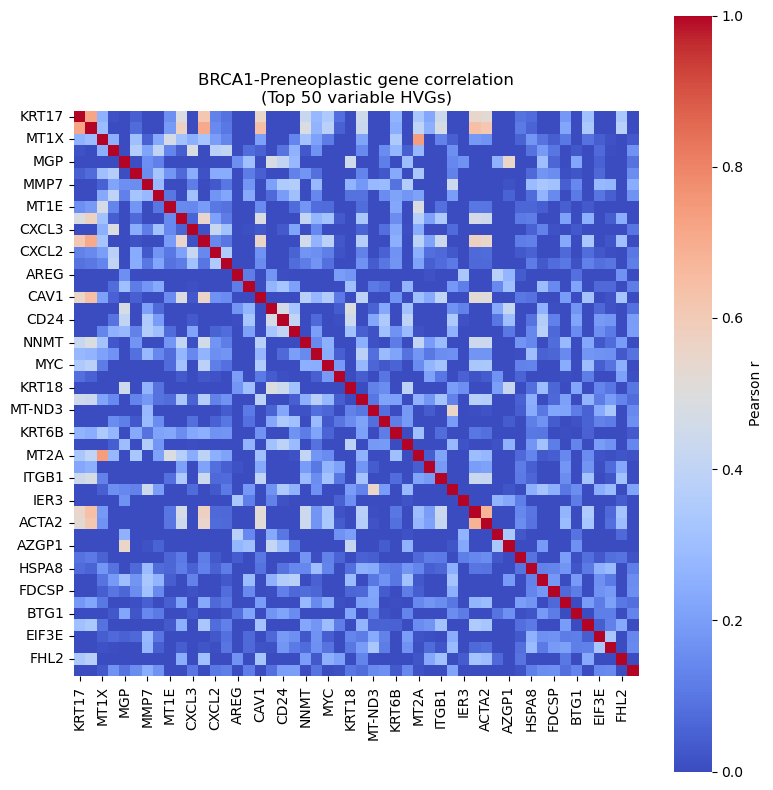

In [12]:
file_path = out_path
hvg_3000 = pd.read_csv("PreB_HVG_3000.txt", header=None)[0].astype(str).tolist()

subset = pd.read_csv(file_path, index_col=0, nrows=5000)
subset = subset[hvg_3000]

gene_var = subset.var(axis=0)
top_n = 50
top_genes = gene_var.sort_values(ascending=False).head(top_n).index.tolist()

chunksize = 2000
corr_data = {g: [] for g in top_genes}

chunk_iter = pd.read_csv(file_path, index_col=0, chunksize=chunksize, low_memory=False)
for ch in chunk_iter:
    ch = ch[top_genes]
    for g in top_genes:
        corr_data[g].extend(ch[g].values.tolist())

corr_df = pd.DataFrame(corr_data)
corr_mat = corr_df.corr(method="pearson")

plt.figure(figsize=(8, 8))
sns.heatmap(
    corr_mat,
    cmap="coolwarm",
    vmin=0.0,
    vmax=1.0,
    square=True,
    cbar_kws={"label": "Pearson r"},
)
plt.title("BRCA1-Preneoplastic gene correlation\n(Top 50 variable HVGs)")
plt.tight_layout()
plt.show()

# Scale, PCA, neighbors, UMAP, Leiden

Scaling genes (PreB)
Computing PCA (PreB)


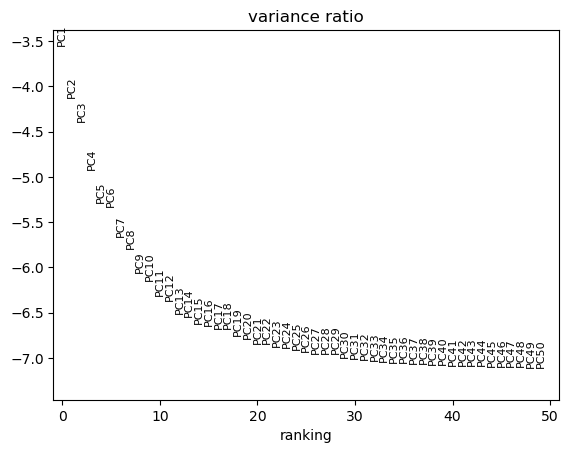

Building neighbor graph (30 PCs)
Computing UMAP (PreB)
Leiden clustering (resolution=0.5)


/triumvirate/apps/.scratch/alexarol/ipykernel_287275/3837298967.py:15: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_preb_hvg, resolution=0.5)


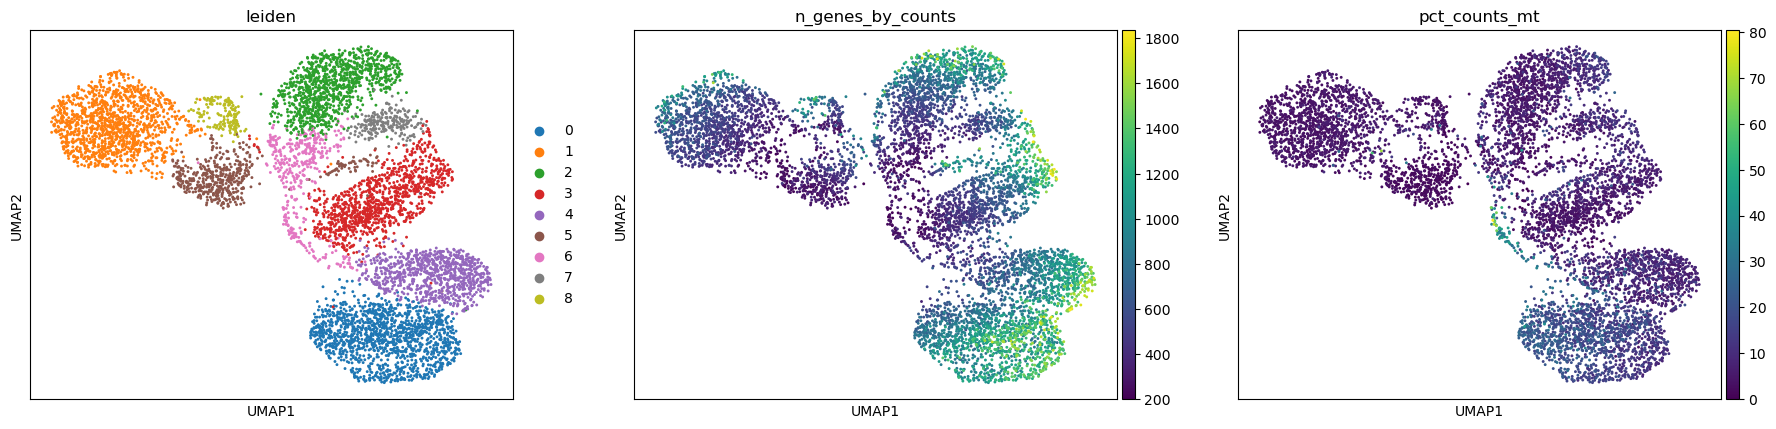

In [13]:
print("Scaling genes (PreB)")
sc.pp.scale(adata_preb_hvg, max_value=10)

print("Computing PCA (PreB)")
sc.tl.pca(adata_preb_hvg, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata_preb_hvg, log=True, n_pcs=50)

print("Building neighbor graph (30 PCs)")
sc.pp.neighbors(adata_preb_hvg, n_pcs=30)

print("Computing UMAP (PreB)")
sc.tl.umap(adata_preb_hvg)

print("Leiden clustering (resolution=0.5)")
sc.tl.leiden(adata_preb_hvg, resolution=0.5)

sc.pl.umap(adata_preb_hvg, color=["leiden", "n_genes_by_counts", "pct_counts_mt"])

# Flag high‑mito clusters

Global pct_mt summary (PreB):
count    6905.000000
mean        8.329654
std         7.169830
min         0.000000
25%         3.590860
50%         5.762712
75%        10.988620
max        80.373360
Name: pct_counts_mt, dtype: float64
Upper whisker ≈ 22.1%

Mean pct_counts_mt per cluster (PreB):
leiden
5     2.632996
8     4.100493
1     4.337502
3     5.587004
2     6.408431
7     7.634385
4     8.637134
6    12.989597
0    16.605437
Name: pct_counts_mt, dtype: float64

High-mt clusters (mean > upper whisker ≈ 22.1%): []


/triumvirate/apps/.scratch/alexarol/ipykernel_287275/1720331039.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_mt = adata_preb_hvg.obs.groupby("leiden")["pct_counts_mt"].mean().sort_values()


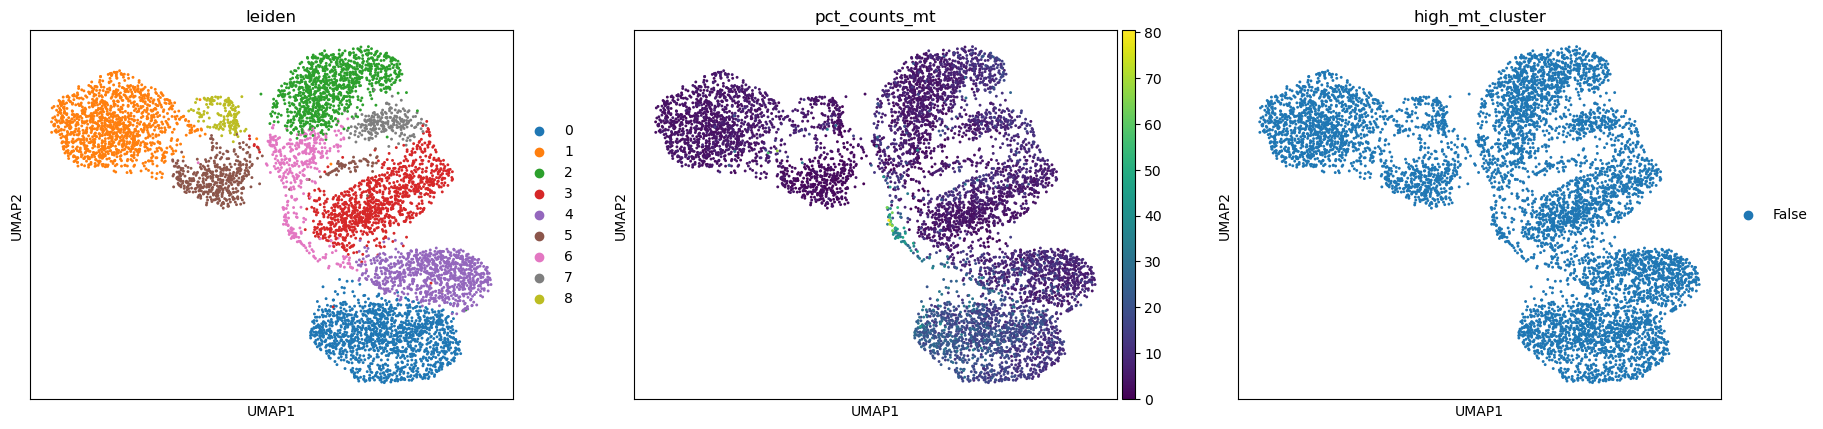

In [14]:
desc = adata_preb_hvg.obs["pct_counts_mt"].describe()
q1, q3 = desc["25%"], desc["75%"]
iqr = q3 - q1
upper_whisker = q3 + 1.5 * iqr

print("Global pct_mt summary (PreB):")
print(desc)
print(f"Upper whisker ≈ {upper_whisker:.1f}%")

cluster_mt = adata_preb_hvg.obs.groupby("leiden")["pct_counts_mt"].mean().sort_values()
print("\nMean pct_counts_mt per cluster (PreB):")
print(cluster_mt)

high_mt_clusters = cluster_mt[cluster_mt > upper_whisker].index.tolist()
print(f"\nHigh-mt clusters (mean > upper whisker ≈ {upper_whisker:.1f}%): {high_mt_clusters}")

adata_preb_hvg.obs["high_mt_cluster"] = adata_preb_hvg.obs["leiden"].isin(high_mt_clusters)

sc.pl.umap(adata_preb_hvg, color=["leiden", "pct_counts_mt", "high_mt_cluster"])

# Save frozen AnnData

In [15]:
frozen_file = "adata_PreB_HVG_UMAP_leiden_frozen.h5ad"
adata_preb_hvg.write_h5ad(frozen_file)
print(f"Saved frozen AnnData to {frozen_file}")

Saved frozen AnnData to adata_PreB_HVG_UMAP_leiden_frozen.h5ad


# Marker genes per cluster (top 20)

In [16]:
print("Computing marker genes per cluster (PreB)")
sc.tl.rank_genes_groups(adata_preb_hvg, groupby="leiden", method="wilcoxon")

n_top = 20
marker_dict = {}

for cluster in adata_preb_hvg.obs["leiden"].cat.categories:
    markers = sc.get.rank_genes_groups_df(adata_preb_hvg, group=cluster).head(n_top)
    marker_dict[cluster] = markers["names"].tolist()
    print(f"Cluster {cluster}: {markers['names'].tolist()[:5]}...")

marker_file = "PreB_cluster_markers_top20.pkl"
with open(marker_file, "wb") as f:
    pickle.dump(marker_dict, f)

print(f"Saved cluster markers to {marker_file}")

Computing marker genes per cluster (PreB)
Cluster 0: ['MT-CO3', 'MT-CO1', 'MT-CO2', 'MT-ND3', 'MT-ND4']...
Cluster 1: ['KRT14', 'KRT17', 'KRT5', 'ITGB1', 'CAV1']...
Cluster 2: ['MALAT1', 'AREG', 'IER3', 'AZGP1', 'HSPB1']...
Cluster 3: ['FTH1', 'HMGA1', 'EEF1B2', 'HINT1', 'B2M']...
Cluster 4: ['NME2', 'GPAT3', 'ALDH1A3', 'CD59', 'LCN2']...
Cluster 5: ['MT2A', 'CRYAB', 'MT1X', 'FAU', 'EIF1']...
Cluster 6: ['MALAT1', 'MT-ND5', 'JUND', 'MGP', 'ANKRD30A']...
Cluster 7: ['HSPB1', 'CIB1', 'MALAT1', 'ADIRF', 'MT-ND1']...
Cluster 8: ['CTSL', 'CXCL2', 'ANXA5', 'APOD', 'GEM']...
Saved cluster markers to PreB_cluster_markers_top20.pkl


/triumvirate/home/alexarol/.conda/envs/breast_cancer_scrnaseq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/triumvirate/home/alexarol/.conda/envs/breast_cancer_scrnaseq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/triumvirate/home/alexarol/.conda/envs/breast_cancer_scrnaseq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/triumvirate/home/alexarol/.conda/envs/breast_cancer_scrnaseq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/triumvirate/home/alexarol/.conda/envs/breast_cancer_scrnase

# Chunked gene‑gene correlation (3000 × 3000)

In [17]:
file_path = out_path
hvg_3000 = pd.read_csv("PreB_HVG_3000.txt", header=None)[0].astype(str).tolist()

chunksize = 800
gene_sum = None
gene_sq_sum = None
n_cells_corr = 0

chunk_iter = pd.read_csv(file_path, index_col=0, chunksize=chunksize, low_memory=False)

print("Computing gene-gene correlation (PreB, pass 1: means)")
for ch in chunk_iter:
    ch = ch[hvg_3000]
    ch_values = ch.values.astype(np.float64)
    
    if gene_sum is None:
        n_genes_corr = ch_values.shape[1]
        gene_sum = np.zeros(n_genes_corr, dtype=np.float64)
        gene_sq_sum = np.zeros(n_genes_corr, dtype=np.float64)
    
    n = ch_values.shape[0]
    n_cells_corr += n
    gene_sum += ch_values.sum(axis=0)
    gene_sq_sum += (ch_values ** 2).sum(axis=0)

gene_mean_corr = gene_sum / n_cells_corr
gene_std = np.sqrt(gene_sq_sum / n_cells_corr - gene_mean_corr**2)

print(f"Pass 1 complete (PreB): {n_cells_corr} cells processed")

cov_matrix = np.zeros((n_genes_corr, n_genes_corr), dtype=np.float64)

chunk_iter = pd.read_csv(file_path, index_col=0, chunksize=chunksize, low_memory=False)

print("Computing gene-gene correlation (PreB, pass 2: covariance)")
for i, ch in enumerate(chunk_iter):
    if i % 20 == 0:
        print(f"  Chunk {i}")
    
    ch = ch[hvg_3000]
    ch_values = ch.values.astype(np.float64)
    
    ch_centered = ch_values - gene_mean_corr
    cov_matrix += ch_centered.T @ ch_centered

cov_matrix /= n_cells_corr
corr_matrix = cov_matrix / np.outer(gene_std, gene_std)
corr_matrix = np.clip(corr_matrix, -1, 1)

print(f"Correlation matrix shape (PreB): {corr_matrix.shape}")
print(f"Min correlation (PreB): {corr_matrix.min():.3f}")
print(f"Max correlation (PreB): {corr_matrix.max():.3f}")

corr_file = "PreB_HVG_correlation_matrix.npy"
np.save(corr_file, corr_matrix)
print(f"Saved correlation matrix to {corr_file}")

Computing gene-gene correlation (PreB, pass 1: means)
Pass 1 complete (PreB): 6905 cells processed
Computing gene-gene correlation (PreB, pass 2: covariance)
  Chunk 0
Correlation matrix shape (PreB): (3000, 3000)
Min correlation (PreB): -0.498
Max correlation (PreB): 1.000
Saved correlation matrix to PreB_HVG_correlation_matrix.npy


# Alternative heatmap (top connected HVGs)

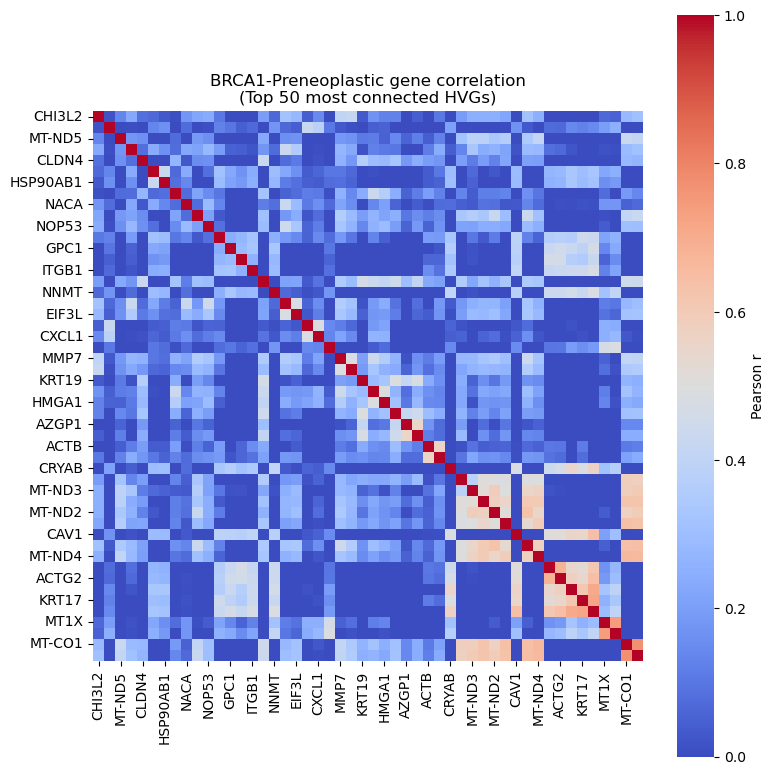

In [18]:
corr_matrix = np.load("PreB_HVG_correlation_matrix.npy")
hvg_3000 = pd.read_csv("PreB_HVG_3000.txt", header=None)[0].astype(str).tolist()

max_abs_r = np.max(np.abs(corr_matrix - np.eye(corr_matrix.shape[0])), axis=1)
top_n = 50
top_idx = np.argsort(max_abs_r)[-top_n:]
top_genes = [hvg_3000[i] for i in top_idx]

sub_corr = corr_matrix[np.ix_(top_idx, top_idx)]
corr_df = pd.DataFrame(sub_corr, index=top_genes, columns=top_genes)

plt.figure(figsize=(8, 8))
sns.heatmap(
    corr_df,
    cmap="coolwarm",
    vmin=0.0,
    vmax=1.0,
    square=True,
    cbar_kws={"label": "Pearson r"},
)
plt.title("BRCA1-Preneoplastic gene correlation\n(Top 50 most connected HVGs)")
plt.tight_layout()
plt.show()

# Build full co‑expression network

In [19]:
corr_matrix = np.load("PreB_HVG_correlation_matrix.npy")
hvg_3000 = pd.read_csv("PreB_HVG_3000.txt", header=None)[0].astype(str).tolist()

threshold = 0.35

edges = []
n_genes_net = len(hvg_3000)

print(f"Building PreB network with |r| >= {threshold}")
for i in range(n_genes_net):
    for j in range(i + 1, n_genes_net):
        r = corr_matrix[i, j]
        if abs(r) >= threshold:
            edges.append((hvg_3000[i], hvg_3000[j], {"weight": r}))

print(f"Found {len(edges)} edges (PreB)")

G_preb = nx.Graph()
G_preb.add_nodes_from(hvg_3000)
G_preb.add_edges_from(edges)

print(f"PreB network: {G_preb.number_of_nodes()} nodes, {G_preb.number_of_edges()} edges")

network_file = "PreB_gene_network_r035.graphml"
nx.write_graphml(G_preb, network_file)
print(f"Saved PreB network to {network_file}")

Building PreB network with |r| >= 0.35
Found 304 edges (PreB)
PreB network: 3000 nodes, 304 edges
Saved PreB network to PreB_gene_network_r035.graphml


# Hub‑gene subnetwork visualization

Top hubs (gene, degree) PreB: [('KRT14', 32), ('CD24', 29), ('KRT5', 22), ('ACTG2', 19), ('CAV1', 18), ('ACTA2', 18), ('KRT17', 16), ('MMP7', 16), ('KRT19', 16), ('KRT18', 16)]
Edges in H (PreB): 209


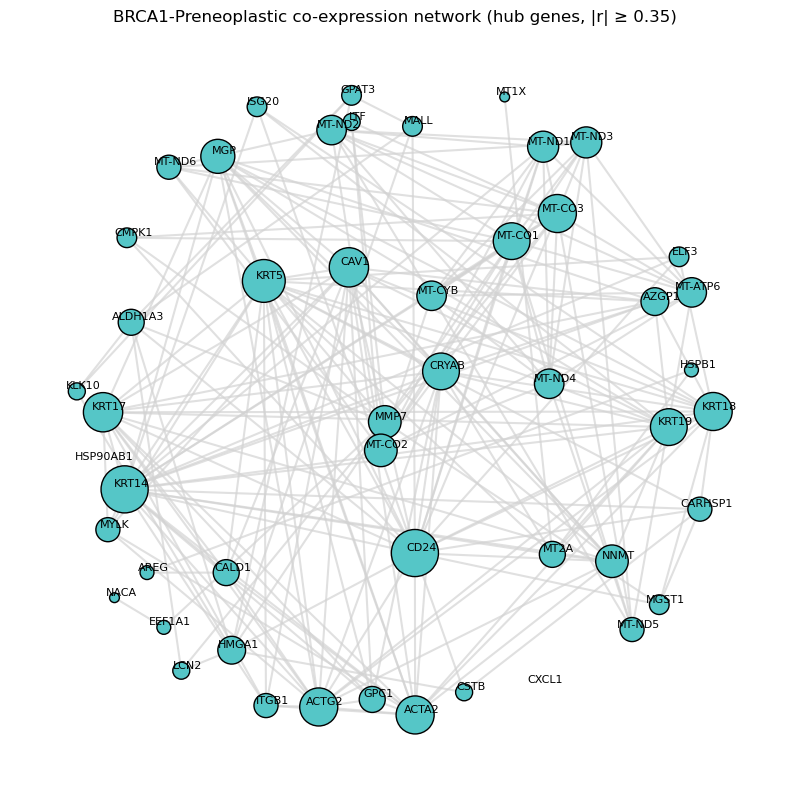

In [20]:
N = 50
degree_dict = dict(G_preb.degree())
top_hubs = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:N]
hub_genes = [g for g, d in top_hubs]

H = G_preb.subgraph(hub_genes).copy()

print("Top hubs (gene, degree) PreB:", top_hubs[:10])
print("Edges in H (PreB):", H.number_of_edges())

pos = nx.spring_layout(H, seed=0, k=1.3)

deg_H = dict(H.degree())
node_sizes = np.array([deg_H[g] for g in H.nodes()]) * 50

plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(H, pos, width=1.5, edge_color="lightgrey", alpha=0.7)
nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color="#55c6c7", edgecolors="black")

for node, (x, y) in pos.items():
    plt.text(
        x + 0.02, y, node,
        fontsize=8,
        ha="center", va="bottom"
    )

plt.title("BRCA1-Preneoplastic co-expression network (hub genes, |r| ≥ 0.35)")
plt.axis("off")
plt.tight_layout()
plt.show()

# Detect modules (Louvain)


In [21]:
print("Detecting modules with Louvain (PreB)")
modules_preb = nx.community.louvain_communities(G_preb, seed=42)

print(f"Found {len(modules_preb)} modules (PreB)")

gene_to_module_preb = {}
for module_id, gene_set in enumerate(modules_preb):
    for gene in gene_set:
        gene_to_module_preb[gene] = module_id

module_sizes = [len(m) for m in modules_preb]
print(f"Module sizes (PreB): min={min(module_sizes)}, max={max(module_sizes)}, median={np.median(module_sizes):.0f}")

with open("PreB_gene_modules.pkl", "wb") as f:
    pickle.dump(modules_preb, f)

with open("PreB_gene_to_module.pkl", "wb") as f:
    pickle.dump(gene_to_module_preb, f)

print("Saved PreB modules to PreB_gene_modules.pkl and PreB_gene_to_module.pkl")

Detecting modules with Louvain (PreB)
Found 2897 modules (PreB)
Module sizes (PreB): min=1, max=36, median=1
Saved PreB modules to PreB_gene_modules.pkl and PreB_gene_to_module.pkl


# Largest connected component plot

PreB largest component: 102 nodes, 294 edges


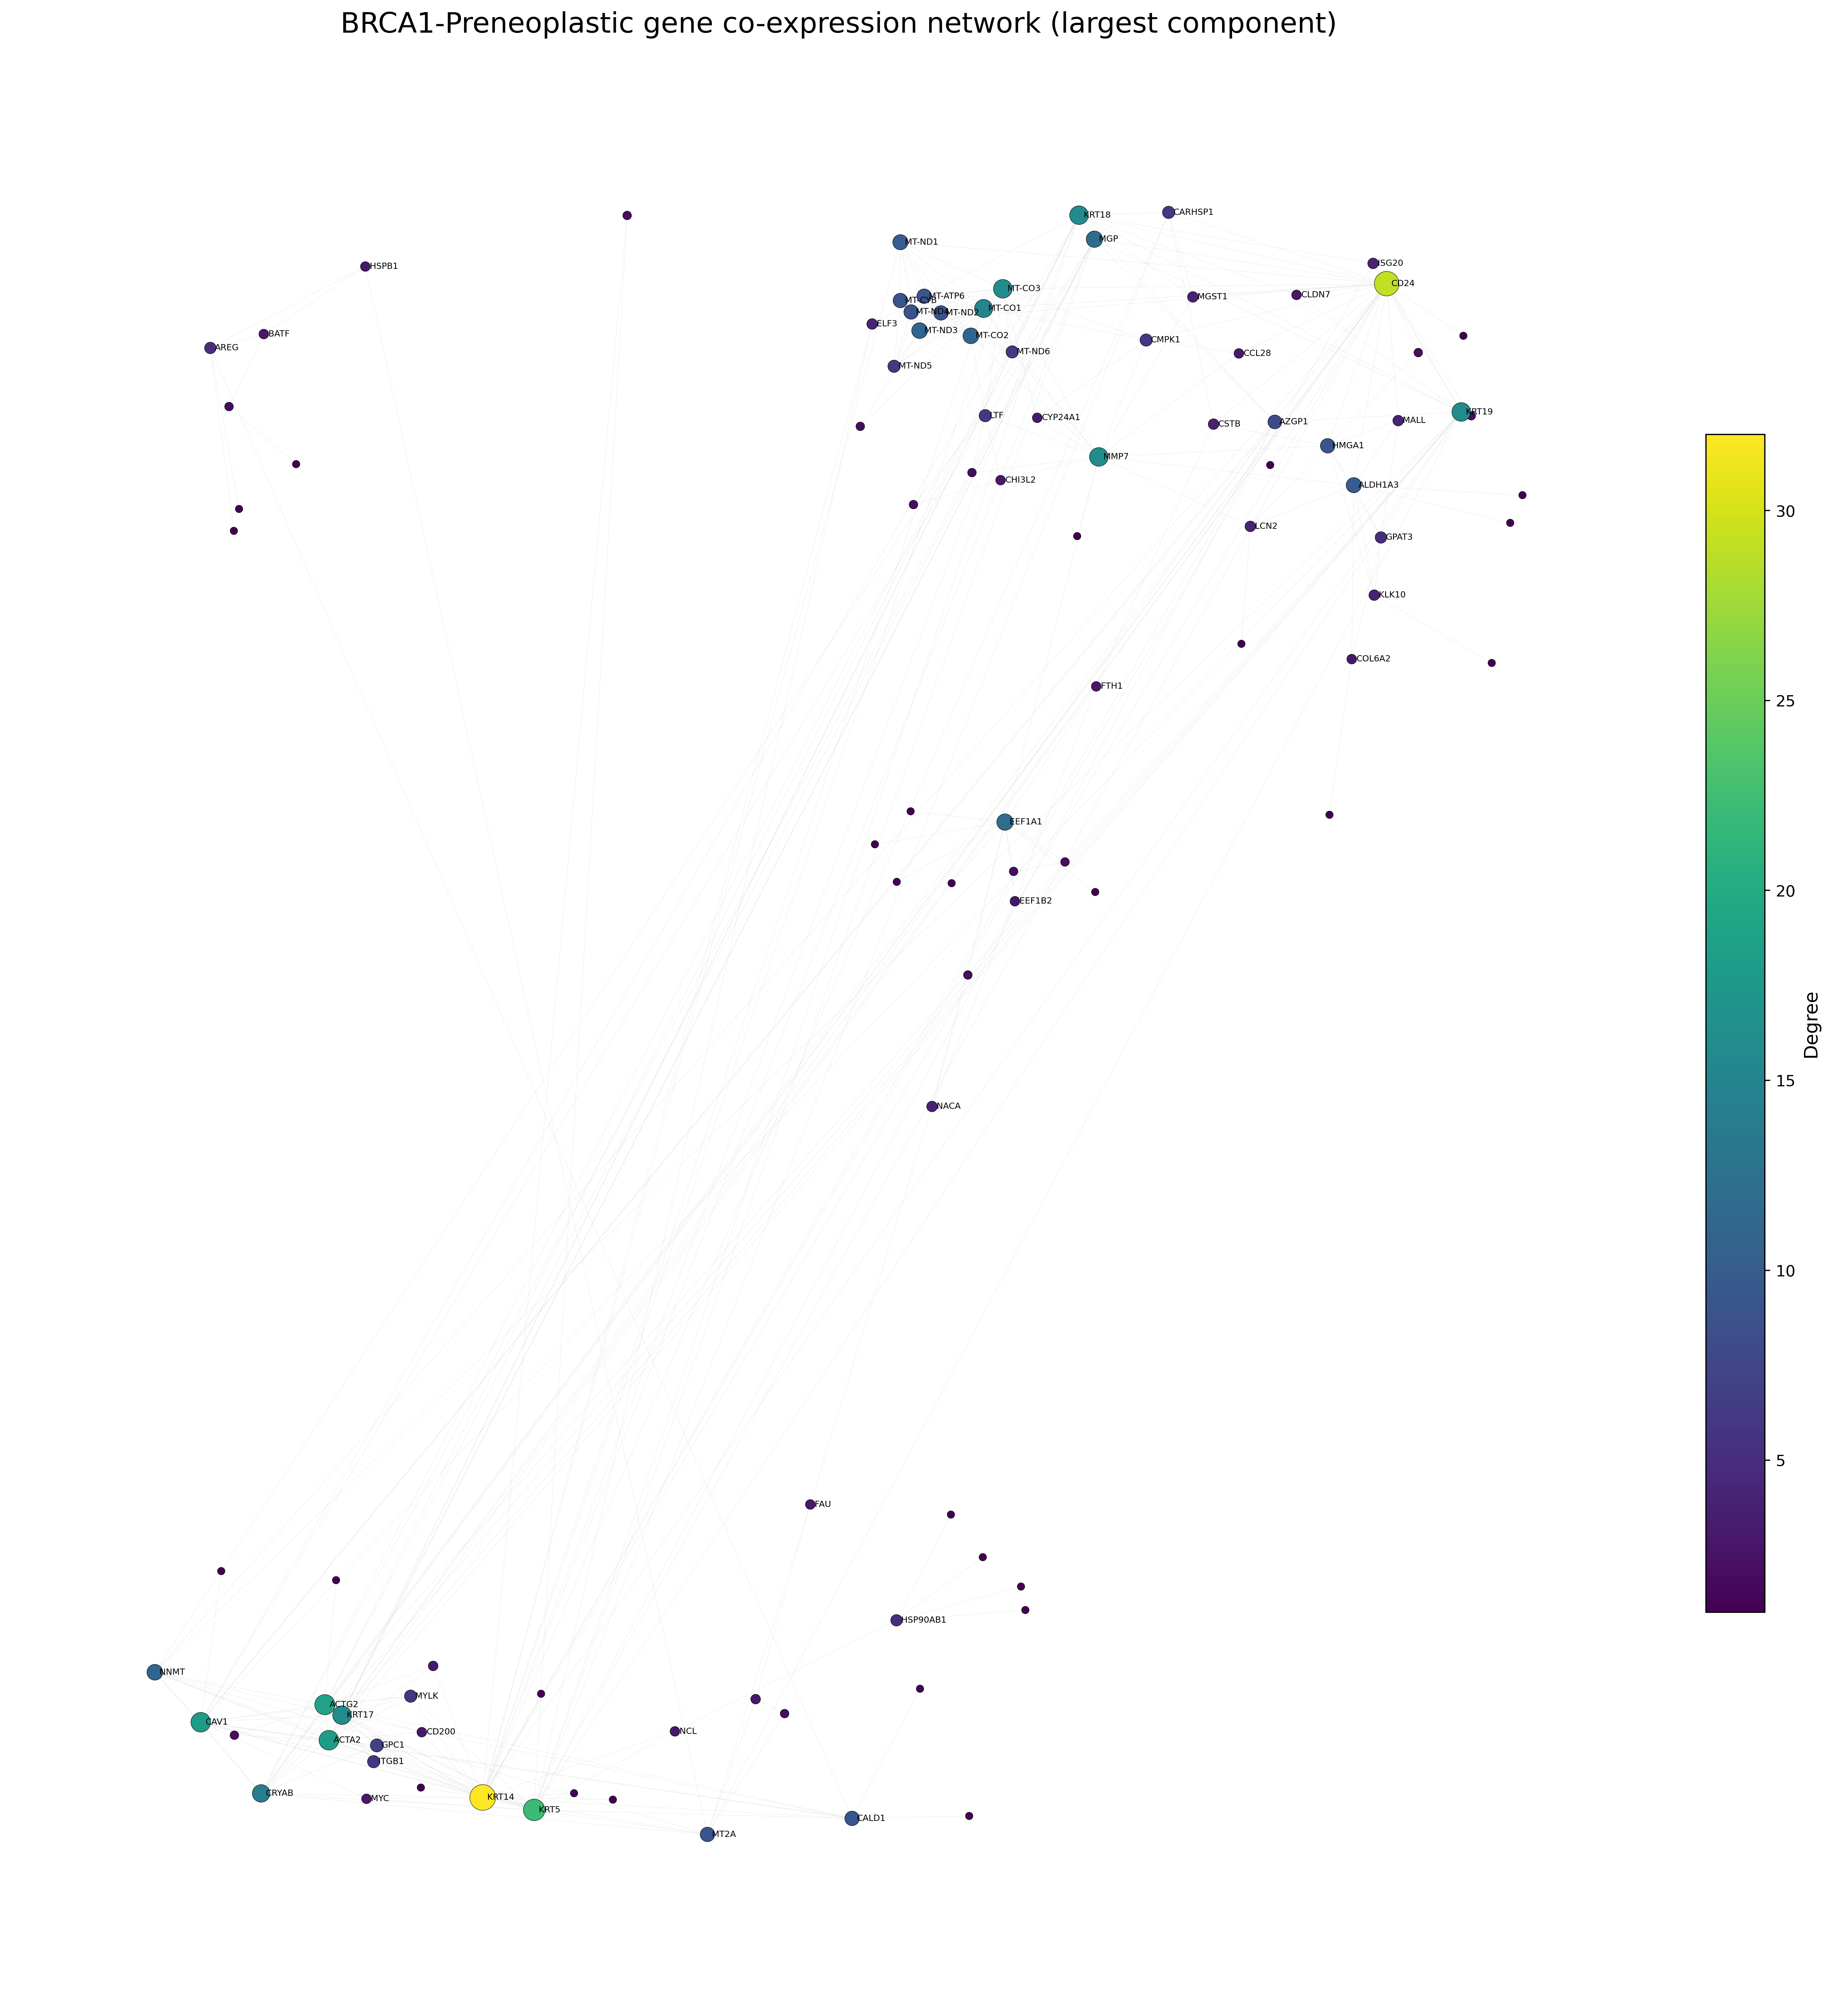

In [22]:
components = list(nx.connected_components(G_preb))
largest = max(components, key=len)
G_preb_lcc = G_preb.subgraph(largest).copy()

print("PreB largest component:", G_preb_lcc.number_of_nodes(), "nodes,", G_preb_lcc.number_of_edges(), "edges")

pos = nx.spring_layout(G_preb_lcc, seed=0, k=0.35, iterations=200)

deg_lcc = dict(G_preb_lcc.degree())
deg_array = np.array([deg_lcc[g] for g in G_preb_lcc.nodes()], dtype=float)

node_sizes = 15 + deg_array * 8

plt.figure(figsize=(18, 18), dpi=400)

nx.draw_networkx_edges(
    G_preb_lcc, pos,
    width=0.2,
    edge_color="grey",
    alpha=0.18,
)

nodes = nx.draw_networkx_nodes(
    G_preb_lcc, pos,
    node_size=node_sizes,
    node_color=deg_array,
    cmap="viridis",
    edgecolors="black",
    linewidths=0.25,
)

cbar = plt.colorbar(nodes, shrink=0.6, pad=0.02)
cbar.set_label("Degree", fontsize=12)

K = 60
top_hubs_lcc = sorted(deg_lcc.items(), key=lambda x: x[1], reverse=True)[:K]
label_genes = set(g for g, d in top_hubs_lcc)

for gene, (x, y) in pos.items():
    if gene in label_genes:
        plt.text(
            x + 0.003, y, gene,
            fontsize=5.5,
            ha="left", va="center",
            color="black",
        )

plt.title("BRCA1-Preneoplastic gene co-expression network (largest component)", fontsize=18)
plt.axis("off")
plt.tight_layout()

plt.savefig(
    "PreB_network_largest_component_pubready.png",
    dpi=600,
    bbox_inches="tight"
)

plt.show()

# Module hub genes

In [23]:
module_hubs_preb = {}

for module_id, gene_set in enumerate(modules_preb):
    subgraph = G_preb.subgraph(gene_set)
    degrees = dict(subgraph.degree())
    
    sorted_genes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
    top_10 = [gene for gene, deg in sorted_genes[:10]]
    
    module_hubs_preb[module_id] = top_10
    print(f"PreB Module {module_id} ({len(gene_set)} genes): {top_10[:5]}...")

with open("PreB_module_hubs_top10.pkl", "wb") as f:
    pickle.dump(module_hubs_preb, f)

print("Saved PreB module hubs to PreB_module_hubs_top10.pkl")

PreB Module 0 (4 genes): ['MT1X', 'MT2A', 'FAU', 'MT1E']...
PreB Module 1 (25 genes): ['KRT14', 'ACTG2', 'ACTA2', 'KRT5', 'CAV1']...
PreB Module 2 (6 genes): ['CXCL1', 'CXCL2', 'CXCL3', 'CCL2', 'CXCL8']...
PreB Module 3 (1 genes): ['C15orf48']...
PreB Module 4 (36 genes): ['CD24', 'MMP7', 'ALDH1A3', 'HMGA1', 'KRT18']...
PreB Module 5 (1 genes): ['KLF6']...
PreB Module 6 (1 genes): ['IER3']...
PreB Module 7 (1 genes): ['KRT6B']...
PreB Module 8 (1 genes): ['ARID5B']...
PreB Module 9 (1 genes): ['HSPA8']...
PreB Module 10 (1 genes): ['GADD45B']...
PreB Module 11 (1 genes): ['JUNB']...
PreB Module 12 (1 genes): ['KRT8']...
PreB Module 13 (1 genes): ['BTG1']...
PreB Module 14 (1 genes): ['CEBPD']...
PreB Module 15 (1 genes): ['LDHA']...
PreB Module 16 (1 genes): ['BIRC3']...
PreB Module 17 (1 genes): ['ACTN1']...
PreB Module 18 (1 genes): ['CYR61']...
PreB Module 19 (1 genes): ['LMNA']...
PreB Module 20 (1 genes): ['ANXA5']...
PreB Module 21 (1 genes): ['NEAT1']...
PreB Module 22 (1 genes)

# Final summary

In [24]:
print("\n" + "="*60)
print("BRCA1-Preneoplastic (PreB) analysis complete!")
print("="*60)
print(f"QC-passed cells (PreB): {adata_preb_hvg.n_obs}")
print(f"HVGs (PreB): {len(hvg_3000)}")
print(f"Leiden clusters (PreB): {len(adata_preb_hvg.obs['leiden'].cat.categories)}")
print(f"Network edges (PreB): {G_preb.number_of_edges()}")
print(f"Modules (PreB): {len(modules_preb)}")
print("\nOutput files:")
print("  - PreB_QC_cells.txt")
print("  - PreB_QC_CP10k_log1p_forWGCNA.csv")
print("  - PreB_HVG_3000.txt")
print("  - adata_PreB_HVG_UMAP_leiden_frozen.h5ad")
print("  - PreB_cluster_markers_top20.pkl")
print("  - PreB_HVG_correlation_matrix.npy")
print("  - PreB_gene_network_r035.graphml")
print("  - PreB_gene_modules.pkl")
print("  - PreB_gene_to_module.pkl")
print("  - PreB_module_hubs_top10.pkl")


BRCA1-Preneoplastic (PreB) analysis complete!
QC-passed cells (PreB): 6905
HVGs (PreB): 3000
Leiden clusters (PreB): 9
Network edges (PreB): 304
Modules (PreB): 2897

Output files:
  - PreB_QC_cells.txt
  - PreB_QC_CP10k_log1p_forWGCNA.csv
  - PreB_HVG_3000.txt
  - adata_PreB_HVG_UMAP_leiden_frozen.h5ad
  - PreB_cluster_markers_top20.pkl
  - PreB_HVG_correlation_matrix.npy
  - PreB_gene_network_r035.graphml
  - PreB_gene_modules.pkl
  - PreB_gene_to_module.pkl
  - PreB_module_hubs_top10.pkl
